#### Importing libraries

In [1]:
import torch, gc
import os
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
from torchvision.datasets.utils import download_url
import matplotlib.pyplot as plt
%matplotlib inline


#### Normalizing stats

In [2]:
stats = ((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

#### Transormations added to normalize and flip images

In [3]:
train_tfms = tt.Compose([
                        tt.RandomHorizontalFlip(),
                        tt.RandomVerticalFlip(),
                        # tt.RandomRotation(30),
                        # tt.RandomAdjustSharpness(1.3),
                        tt.ToTensor(),
                        tt.Normalize(*stats,inplace=True)
                        ])
test_tfms = tt.Compose([tt.ToTensor(),tt.Normalize(*stats)])

#### Creating training dataset and test dataset

In [4]:
train_ds = ImageFolder('malware_dataset/train',train_tfms)
test_ds = ImageFolder('malware_dataset/valid',test_tfms)

In [5]:
train_ds.classes

['benign', 'malware']

In [6]:
batch_size = 24

#### Specifying dataloaders

In [8]:
train_dl = DataLoader(train_ds,batch_size,shuffle=True,num_workers=3,pin_memory=True)
test_dl = DataLoader(test_ds,batch_size*2,num_workers=3,pin_memory=True)

##### Functions for denormalization and checking data

In [7]:
def denormalize(images,means,stds):
    means = torch.tensor(means).reshape(1,3,1,1)
    stds = torch.tensor(stds).reshape(1,3,1,1)
    return images*stds+means

def show_batch(dl):
    for images,labels in dl:
        fig, ax = plt.subplots(figsize=(12,12))
        ax.set_xticks([]);ax.set_yticks([])
        denorm_images =  denormalize(images, *stats)
        ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1,2,0).clamp(0,1))
        break

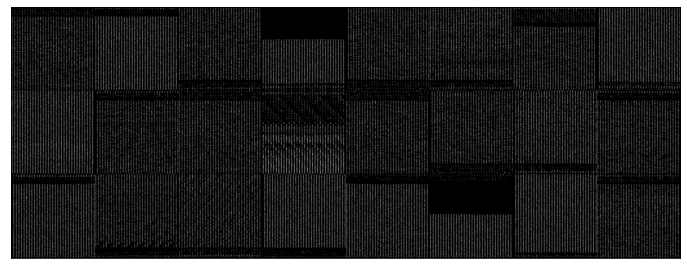

In [10]:
show_batch(train_dl)

#### Using GPU for computation

In [9]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [10]:
device = get_default_device()
device

device(type='cuda')

#### Loading dataloader to GPU

In [11]:
train_dl = DeviceDataLoader(train_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

#### Functions for evaluation of diffrent parameters like accuracy and loss.

In [42]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)              # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        # saving model above 85% accuracy
        if epoch_acc.item() > 0.96:
            torch.save(model.state_dict(), 'weights/malware_detect_{}.pth'.format(epoch_acc.item()))
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

# Muznet

In [39]:
class MuzNet256(ImageClassificationBase):
    def __init__(self,in_channels,num_classes):
        super().__init__()

        """
            Normalizing Layers
        """
        self.norm15 = nn.BatchNorm2d(15)
        self.norm30 = nn.BatchNorm2d(30)
        self.norm60 = nn.BatchNorm2d(60)
        self.norm120 = nn.BatchNorm2d(120)
        self.norm240 = nn.BatchNorm2d(240)
        self.norm480 = nn.BatchNorm2d(480)
        self.norm550 = nn.BatchNorm2d(550)

        """
            Convolutional Layers
        """

        #in: in_channels X 256 X 256
        self.conv15 = nn.Conv2d(in_channels=in_channels,out_channels=15,kernel_size=3,stride=2,padding=1) #--> 15 x 128 x 128
        self.conv30 = nn.Conv2d(in_channels=15,out_channels=30,kernel_size=3,stride=1,padding=1) #--> 30 x 128 x 128

        # conv30 + res30 --> residual block
        self.res30 = nn.Conv2d(in_channels=30,out_channels=30,kernel_size=3,stride=1,padding=1) #--> 30 x 128 x 128

        self.conv60 = nn.Conv2d(in_channels=30,out_channels=60,kernel_size=3,stride=2,padding=1) #--> 60 x 64 x 64
        self.conv120 = nn.Conv2d(in_channels=60,out_channels=120,kernel_size=3,stride=1,padding=1) #--> 120 x 64 x 64

        # conv120 + res120 --> residual block
        self.res120 = nn.Conv2d(in_channels=120,out_channels=120,kernel_size=3,stride=1,padding=1) #--> 120 x 64 x 64
        
        self.conv240 = nn.Conv2d(in_channels=120,out_channels=240,kernel_size=3,stride=2,padding=1) #--> 240 x 32 x 32
        self. conv480 = nn.Conv2d(in_channels=240,out_channels=480,kernel_size=3,stride=1,padding=1) #--> 480 x 32 x 32

        # conv480 + res480 --> residual block
        self.res480 = nn.Conv2d(in_channels=480,out_channels=480,kernel_size=3,stride=1,padding=1) #--> 480 x 32 x 32

        self.conv550 = nn.Conv2d(in_channels=480,out_channels=550,kernel_size=3,stride=2,padding=1) #--> 550 x 16 x 16
        
        self.avgpool = nn.AvgPool2d(2,2) #--> 550 x 8 x 8
        self.flat = nn.Flatten()
        self.linear = nn.Linear(550*8*8,num_classes)

    def forward(self,inputs):

        out = torch.relu(self.norm15(self.conv15(inputs))) #--> 15 x 128 x 128
        
        rb = torch.relu(self.norm30(self.conv30(out))) #
        
        out = torch.relu(self.res30(rb)+rb)
        

        out = torch.relu(self.norm60(self.conv60(out)))
        rb = torch.relu(self.norm120(self.conv120(out)))

        out = torch.relu(self.res120(rb)+rb)

        out = torch.relu(self.norm240(self.conv240(out)))
        rb = torch.relu(self.norm480(self.conv480(out)))

        out = torch.relu(self.res480(rb)+rb)

        out = torch.relu(self.norm550(self.conv550(out)))

        out = self.avgpool(out)
        # print(f"Out shape avgpool: {out.shape}")
        out = self.flat(out)
        # print(f"Out shape flat: {out.shape}")
        out = self.linear(out)
        out = torch.softmax(out,dim=1)

        return out




        


#### Clearing GPU cache

In [32]:
gc.collect()
torch.cuda.empty_cache()

#### Uploading model to GPU

In [40]:
model = to_device(MuzNet256(3,2),device)
model

MuzNet256(
  (norm15): BatchNorm2d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm30): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm60): BatchNorm2d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm120): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm240): BatchNorm2d(240, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm480): BatchNorm2d(480, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm550): BatchNorm2d(550, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv15): Conv2d(3, 15, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv30): Conv2d(15, 30, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (res30): Conv2d(30, 30, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv60): Conv2d(30, 60, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv120): Conv2d(60, 120

### Training Function

In [25]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

### Training parameters

In [43]:
epochs = 10
max_lr = 0.0001
grad_clip = 0.1
weight_decay = 1e-5
opt_func = torch.optim.Adam

### Training phase

In [44]:
ret_data = fit_one_cycle(epochs,max_lr,model,train_dl,test_dl,weight_decay,grad_clip,opt_func)

Epoch [0], last_lr: 0.00003, train_loss: 0.3961, val_loss: 0.3711, val_acc: 0.9306
Epoch [1], last_lr: 0.00008, train_loss: 0.3859, val_loss: 0.3562, val_acc: 0.9583
Epoch [2], last_lr: 0.00010, train_loss: 0.3787, val_loss: 0.3500, val_acc: 0.9653
Epoch [3], last_lr: 0.00010, train_loss: 0.3691, val_loss: 0.3511, val_acc: 0.9583
Epoch [4], last_lr: 0.00008, train_loss: 0.3619, val_loss: 0.3737, val_acc: 0.8958
Epoch [5], last_lr: 0.00006, train_loss: 0.3585, val_loss: 0.3407, val_acc: 0.9653
Epoch [6], last_lr: 0.00004, train_loss: 0.3498, val_loss: 0.3275, val_acc: 0.9861
Epoch [7], last_lr: 0.00002, train_loss: 0.3449, val_loss: 0.3298, val_acc: 0.9792
Epoch [8], last_lr: 0.00000, train_loss: 0.3423, val_loss: 0.3208, val_acc: 0.9931
Epoch [9], last_lr: 0.00000, train_loss: 0.3414, val_loss: 0.3203, val_acc: 0.9931


# Evaluate your own validation dataset.

In [28]:
torch.save(model.state_dict(),"malware_weight_99.pth")

In [ ]:
def validate_results(path_to_validation_data):
    val_ds = ImageFolder(path_to_validation_data,test_tfms)
    val_dl = DataLoader(val_ds,batch_size=32,shuffle=True,num_workers=3,pin_memory=True)
    model = MuzNet256(3,2)
    model.load_state_dict(torch.load("weights/malware_detect_0.9930555820465088.pth"))
    results = evaluate(model,val_dl)
    return results

print(validate_results("malware_dataset/valid"))

### Functions for plotting graphs

In [45]:
def plot_accuracies(history):
  accuracies = [x['val_acc'] for x in history]
  plt.plot(accuracies, '-x')
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.title('Acc vs Epochs')

def plot_loss(history):
  loss = [x['val_loss'] for x in history]
  plt.plot(loss, '-x')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.title('Loss vs Epochs')

def plot_lr(history):
  lr = [x['lrs'] for x in history]
  plt.plot(lr, '-x')
  plt.xlabel('epoch')
  plt.ylabel('learning_rates')
  plt.title('Learning_rates vs Epochs')

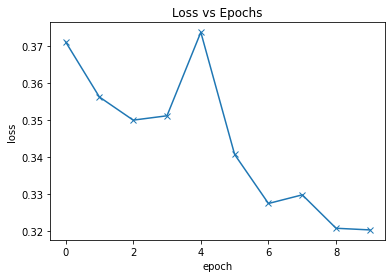

In [46]:
plot_loss(ret_data)

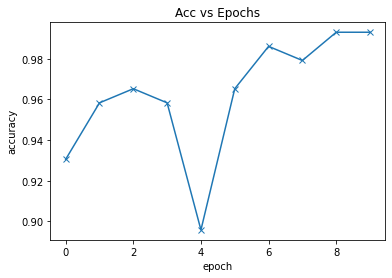

In [47]:
plot_accuracies(ret_data)

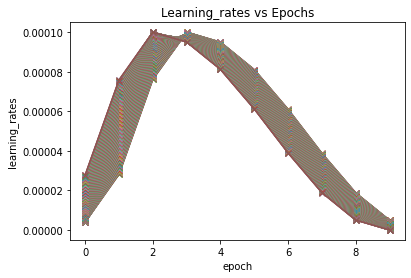

In [48]:
plot_lr(ret_data)

### Function for predicting Image

In [49]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    a, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return train_ds.classes[preds[0].item()]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 256, 256])
Label: benign , Predicted: benign


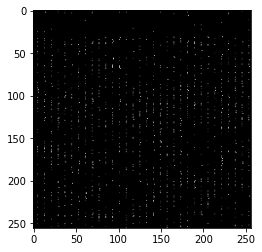

In [50]:
img, label = test_ds[45]
print(img.shape)
plt.imshow(img.permute(1, 2, 0))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))